In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import json
from datetime import datetime

This notebook expects a single environment variable, `METADATA`, to be set to the location of the metadata file you want processed. If running interactively, uncomment the below cell to set this parameter within the notebook environment. 

This notebook will create three plots: 

1. an unmodified cost file (not saved by default)
2. cost per task, merging split/main/join tasks with the same prefix
3. run time per task, merging split/main/join tasks with the same prefix

In addition, it will print the total run time in wall clock hours and cpu hours, as well as the total cost across all tasks. 

In [2]:
# to run interactively, uncomment the line below
# os.environ['METADATA'] = 'path_to_metadata.json'

In [3]:
if 'METADATA' not in os.environ:
    raise RuntimeError('METADATA variable not set')

In [4]:
%%bash
# download cost script
curl -o ${TMPDIR}get_cost.py https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/accessories/calculate_workflow_cost.py 2>&1 > /dev/null

# run the cost script on the metadata
python2.7 ${TMPDIR}/get_cost.py -m ${METADATA} > ./cost_data.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9576  100  9576    0     0  37274      0 --:--:-- --:--:-- --:--:-- 37406


In [5]:
# load the data
cost_results = pd.read_table('./cost_data.txt', index_col=0)

In [6]:
def barplot(dataframe, column, label, filename=None):
    f, ax = plt.subplots(figsize=(8, 5))
    plt.bar(left=np.arange(dataframe.shape[0]), height=dataframe[column])
    plt.xticks(np.arange(dataframe.shape[0]), list(dataframe.index), rotation=90);
    ax.set_xlim((-0.6, dataframe.shape[0] - 0.4));
    ax.set_ylabel(label)
    f.tight_layout()
    if filename:
        f.savefig(filename, dpi=150)
    return f, ax

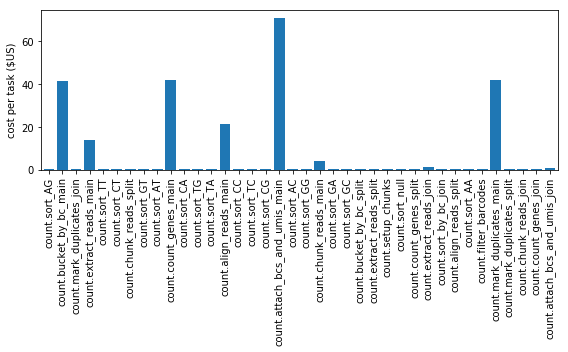

In [7]:
# plot unmodified cost
barplot(cost_results, 'total_cost', 'cost per task ($US)');

In [8]:
# merge the sort tasks
sort_tasks = [name for name in cost_results.index if name.startswith('count.sort')]
merged_sort = cost_results.loc[sort_tasks].sum(axis=0)
cost_results = cost_results.drop(sort_tasks, axis=0)
merged_sort.name = 'count.sort'
cost_results = cost_results.append(merged_sort)

# merge the join/main/split
cost_results.index = [name.replace('count.', '').replace('_main', '').replace('_join', '').replace('_split', '') 
                      for name in cost_results.index]
cost_results_numeric = cost_results.groupby(level=0, axis=0).sum()

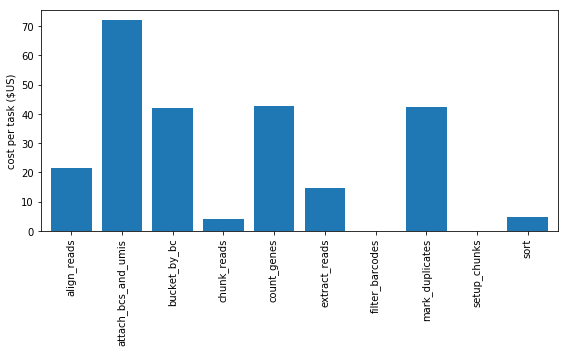

In [9]:
# plot cost
barplot(cost_results_numeric, 'total_cost', 'cost per task ($US)', './cost.png');

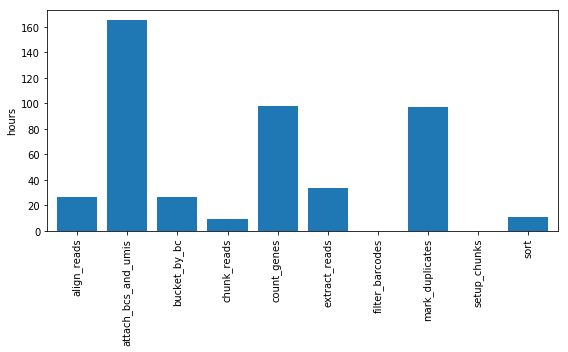

In [10]:
# plot time
barplot(cost_results_numeric, 'total_hours', 'hours', 'timing.png');

In [11]:
# print wall clock time and total cost
with open(os.environ['METADATA'], 'rb') as f:
    metadata = json.load(f)

# get wall time
timefmt = '%Y-%m-%dT%H:%M:%S.%fZ'
start = datetime.strptime(metadata['start'], timefmt)
end = datetime.strptime(metadata['end'], timefmt)
timedelta = start - end
hours_elapsed = timedelta.seconds / 3600

# get money
total_cost = cost_results['total_cost'].sum()

# get cpu time
total_hours = cost_results['total_hours'].sum()

print('total wall clock time: %.2f' % hours_elapsed)
print('total cpu hours: %.2f' % total_hours)
print('total cost ($US): %.2f' % total_cost)

total wall clock time: 6.14
total cpu hours: 468.40
total cost ($US): 244.01
